<div style="float:left">
    <h1 style="width:600px">Objective 1: Spatial Analysis: Accessibility</h1>
</div>
<div style="float:right"><img width="100" src="https://github.com/jreades/i2p/raw/master/img/casa_logo.jpg" /></div>

# 0. Library preparation

In [2]:
import datetime
now = datetime.datetime.now()
print("Last executed: " + now.strftime("%Y-%m-%d %H:%M:%S"))

Last executed: 2024-08-26 11:49:24


### Fiona & Gdal

In [5]:
import fiona
from osgeo import gdal

print(fiona.__version__)
print(gdal.__version__)

1.9.5
3.6.4


### Geopandas

In [7]:
import geopandas as gpd
print(gpd.__version__)
# import r5py as r5py
# from r5py.sampledata import helsinki, sao_paulo

0.14.2


### pyproj Lib

In [9]:
import pyproj

crs = pyproj.CRS("EPSG:27700")
print(crs)
# EPSG:27700

EPSG:27700


### Other Libs

In [11]:
import pandas as pd
from sklearn.linear_model import LinearRegression

import numpy as np

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import matplotlib
# import seaborn as sn

from time import time

### R5py

In [13]:
import r5py
print(r5py.__version__)

0.1.1


In [14]:
pip show r5py

Name: r5py
Version: 0.1.1
Summary: Python wrapper for the R5 routing analysis engine
Home-page: 
Author: Willem Klumpenhouwer, Marcus Sairava, Rafael Pereira, Henrikki Tenkanen
Author-email: Christoph Fink <christoph.fink@helsinki.fi>
License: GPL-3.0-or-later or MIT
Location: C:\Users\avb19\anaconda3\envs\r5py\Lib\site-packages
Requires: ConfigArgParse, filelock, fiona, geopandas, importlib-resources, joblib, jpype1, numpy, pandas, psutil, pyproj, requests, shapely
Required-by: 
Note: you may need to restart the kernel to use updated packages.


### Other_Libs

In [16]:
import shapely
print("shapely version:", shapely.__version__)

shapely version: 2.0.2


### Transport network Introduction

Virtually all operations of r5py require a transport network. R5py understands and reads the following types of transport networks:

a street network, including infrastructure for cycling and walking, is loaded from an OpenStreetMap extract in Protocol Buffer (.pbf) format (mandatory)

a public transport schedule from one or more GTFS files (optional).

For the quickstart example, you find sample data sets in the r5py.sampledata.helsinki package (see above).

To import the street and public transport networks, instantiate an r5py.TransportNetwork with the file paths to the OSM extract and to zero or more GTFS files. With the sample data set, the file paths are in the r5py.sampledata.helsinki namespace:

# Start the analysis of Greater London

## 1.1 London LSOAs Geojson File

In [23]:
# Import Libs
import geopandas as gpd

# Reading geojson files 
London_LSOA_gdf = gpd.read_file("Data/London_second_phase/London_LSOA_2021.geojson")

In [24]:
London_LSOA_gdf.crs

<Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.0, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

In [25]:
# Convert GeoDataFrame to DataFrame
London_LSOA_dropped = London_LSOA_gdf.to_crs(epsg='27700')

## 1.2 London Library locations: Cultural Infrastructure Map 2023

In [28]:
import pandas as pd

CIM_library = pd.read_csv('Data/London/CIM 2023 Libraries (Nov 2023).csv')

In [29]:
df = CIM_library.copy()

In [30]:
# Create a GeoDataFrame of a geographic coordinate system

# EPSG=4326
gdf_geo = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
gdf_geo = gdf_geo.set_crs(epsg=4326)

# EPSG=27700
gdf_proj = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.easting, df.northing))
gdf_proj = gdf_proj.set_crs(epsg=27700)

# Verify
print(gdf_geo.crs)
print(gdf_proj.crs)

EPSG:4326
EPSG:27700


In [31]:
gdf_proj.head(2)

name address1 address2  address3 borough_name  website  \
0  Wembley Library      NaN      NaN       NaN        Brent      NaN   
1          Kilburn      NaN      NaN       NaN        Brent      NaN   

   os_addressbase_uprn borough_code ward_2022_name ward_2022_code   latitude  \
0                  NaN    E09000005   Wembley Park      E05013516  51.558409   
1          202046410.0    E09000005    Queens Park      E05013507  51.534607   

   longitude      easting     northing                       geometry  
0  -0.279883  519339.8475  185793.3494  POINT (519339.847 185793.349)  
1  -0.203802  524678.5649  183273.2007  POINT (524678.565 183273.201)

In [33]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from pyrosm import OSM

## 1.3 Origins

In [36]:
origins = London_LSOA_dropped.copy()

In [37]:
origins['id'] = origins['FID'] 

In [38]:
# origins.crs
# #<Projected CRS: EPSG:27700>; Name: OSGB36 / British National Grid

In [39]:
origins.head(2)
# Now the column "geometry" is "polygon"

FID   LSOA21CD             LSOA21NM   BNG_E   BNG_N     LONG       LAT  \
0    1  E01000001  City of London 001A  532123  181632 -0.09714  51.51816   
1    2  E01000002  City of London 001B  532480  181715 -0.09197  51.51882   

                               GlobalID  \
0  c0565620-19c9-46e4-aea5-7031bb89b7d2   
1  6aac6ffa-0cca-4aec-9a0a-1eeace1ea636   

                                            geometry  id  
0  POLYGON ((532151.537 181867.433, 532152.500 18...   1  
1  POLYGON ((532634.497 181926.016, 532632.048 18...   2

In [40]:
origins_1 = origins.copy()

In [41]:
origins_1.geometry = origins_1.geometry.centroid
# Convert the column "geometry " from "polygon" to the centroid of the polygon "point"

In [42]:
origins_1.head(2)

FID   LSOA21CD             LSOA21NM   BNG_E   BNG_N     LONG       LAT  \
0    1  E01000001  City of London 001A  532123  181632 -0.09714  51.51816   
1    2  E01000002  City of London 001B  532480  181715 -0.09197  51.51882   

                               GlobalID                       geometry  id  
0  c0565620-19c9-46e4-aea5-7031bb89b7d2  POINT (532150.840 181617.461)   1  
1  6aac6ffa-0cca-4aec-9a0a-1eeace1ea636  POINT (532443.368 181643.603)   2

## 1.4 Destinations: Public library locations

In [44]:
destinations_all = gdf_proj.copy()

In [45]:
destinations_all["id"] = destinations_all.index

In [46]:
destinations_all.head(2)

name address1 address2  address3 borough_name  website  \
0  Wembley Library      NaN      NaN       NaN        Brent      NaN   
1          Kilburn      NaN      NaN       NaN        Brent      NaN   

   os_addressbase_uprn borough_code ward_2022_name ward_2022_code   latitude  \
0                  NaN    E09000005   Wembley Park      E05013516  51.558409   
1          202046410.0    E09000005    Queens Park      E05013507  51.534607   

   longitude      easting     northing                       geometry  id  
0  -0.279883  519339.8475  185793.3494  POINT (519339.847 185793.349)   0  
1  -0.203802  524678.5649  183273.2007  POINT (524678.565 183273.201)   1

# 2. Compute and Plot

## 2.0 Python libraries

In [48]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from scipy.spatial import cKDTree

print(shapely.__version__)
# print(scipy.__version__)

2.0.2


## 2.1 Destinations: Public library locations

In [50]:
# libraries_gdf contains information about libraries and the geometry column
# Libraries are the destination
libraries_gdf_1 = destinations_all.copy()

In [51]:
libraries_gdf_1.head(3)

name address1 address2  address3 borough_name  website  \
0  Wembley Library      NaN      NaN       NaN        Brent      NaN   
1          Kilburn      NaN      NaN       NaN        Brent      NaN   
2   Bradmore Green      NaN      NaN       NaN      Croydon      NaN   

   os_addressbase_uprn borough_code ward_2022_name ward_2022_code   latitude  \
0                  NaN    E09000005   Wembley Park      E05013516  51.558409   
1         2.020464e+08    E09000005    Queens Park      E05013507  51.534607   
2         2.000000e+11    E09000008   Old Coulsdon      E05011474  51.307033   

   longitude      easting     northing                       geometry  id  
0  -0.279883  519339.8475  185793.3494  POINT (519339.847 185793.349)   0  
1  -0.203802  524678.5649  183273.2007  POINT (524678.565 183273.201)   1  
2  -0.122405  530972.1080  158108.6541  POINT (530972.108 158108.654)   2

In [52]:
libraries_gdf_1.index.max()

346

In [53]:
# libraries_gdf_1['Library_Index'] = libraries_gdf_1.index

In [54]:
# libraries_gdf_1.crs
# # <Projected CRS: EPSG:27700>
# # Name: OSGB36 / British National Grid

## 2.2 Origins: LSOAs centroid

In [18]:
# lsoa_gdf contains LSOA IDs and the coordinates of the centroid
lsoa_gdf_1 = origins_1.copy()

In [57]:
lsoa_gdf_1['id'] = lsoa_gdf_1['FID']

In [58]:
lsoa_gdf_1.head(2)

FID   LSOA21CD             LSOA21NM   BNG_E   BNG_N     LONG       LAT  \
0    1  E01000001  City of London 001A  532123  181632 -0.09714  51.51816   
1    2  E01000002  City of London 001B  532480  181715 -0.09197  51.51882   

                               GlobalID                       geometry  id  
0  c0565620-19c9-46e4-aea5-7031bb89b7d2  POINT (532150.840 181617.461)   1  
1  6aac6ffa-0cca-4aec-9a0a-1eeace1ea636  POINT (532443.368 181643.603)   2

In [59]:
# lsoa_gdf_1.crs
# # <Projected CRS: EPSG:27700>
# # Name: OSGB36 / British National Grid

## 2.3 Nearest Neighbor Analysis: To make up OD pairs

In [61]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
from shapely.geometry import LineString

# Ensure all data uses the same Coordinate Reference System (CRS)
print("LSOA CRS:", lsoa_gdf_1.crs)
print("Libraries CRS:", libraries_gdf_1.crs)

# Ensure the coordinate reference system is EPSG:27700
assert lsoa_gdf_1.crs == libraries_gdf_1.crs == "EPSG:27700"

# Extract the coordinates of the LSOA centroids
lsoa_coords = [(geom.x, geom.y) for geom in lsoa_gdf_1.geometry]
print("LSOA Coordinates:", lsoa_coords[:5])   # Print the first 5 LSOA coordinates for verification

# Extract the coordinates of the libraries
library_coords = [(geom.x, geom.y) for geom in libraries_gdf_1.geometry]
print("Library Coordinates:", library_coords[:5])  # Print the first 5 library coordinates for verification



# Perform nearest neighbor analysis using cKDTree
tree = cKDTree(library_coords)
distances, indices = tree.query(lsoa_coords, k=1)

print("Distances:", distances[:5])  # Print the first 5 distances for verification
print("Indices:", indices[:5])      # Print the first 5 indices for verification

# Check the indices and data type of the library DataFrame
print("Library DataFrame Index:", libraries_gdf_1.index)

# Add the results to the LSOA GeoDataFrame
lsoa_gdf_1['Nearest_Library_ID'] = libraries_gdf_1.iloc[indices].index.values
lsoa_gdf_1['Distance_to_Library'] = distances

# Output the results
print(lsoa_gdf_1[['LSOA21CD', 'Nearest_Library_ID', 'Distance_to_Library']].head())



# Create a new GeoDataFrame to store the lines from LSOA centroids to the nearest libraries
lines = []

for i, row in lsoa_gdf_1.iterrows():
    lsoa_point = row.geometry
    library_index = row['Nearest_Library_ID']
    library_point = libraries_gdf_1.loc[library_index].geometry
    line = LineString([lsoa_point, library_point])
    lines.append(line)

lines_gdf = gpd.GeoDataFrame(geometry=lines, crs="EPSG:27700")

LSOA CRS: EPSG:27700
Libraries CRS: EPSG:27700
LSOA Coordinates: [(532150.8395557334, 181617.46093460597), (532443.3684903808, 181643.60326146887), (532205.5452751239, 182030.04891339995), (533620.0493561976, 181152.84073152635), (544933.4507922354, 184296.48090885128)]
Library Coordinates: [(519339.8475, 185793.3494), (524678.5649, 183273.2007), (530972.108, 158108.6541), (542020.3836, 158922.5458), (529913.0368, 159465.8282)]
Distances: [333.57878168 139.44336652 340.88010596 186.5628679  601.19501564]
Indices: [183 183 183 175 216]
Library DataFrame Index: RangeIndex(start=0, stop=347, step=1)
    LSOA21CD  Nearest_Library_ID  Distance_to_Library
0  E01000001                 183           333.578782
1  E01000002                 183           139.443367
2  E01000003                 183           340.880106
3  E01000005                 175           186.562868
4  E01000006                 216           601.195016


## 2.4 NNA figure

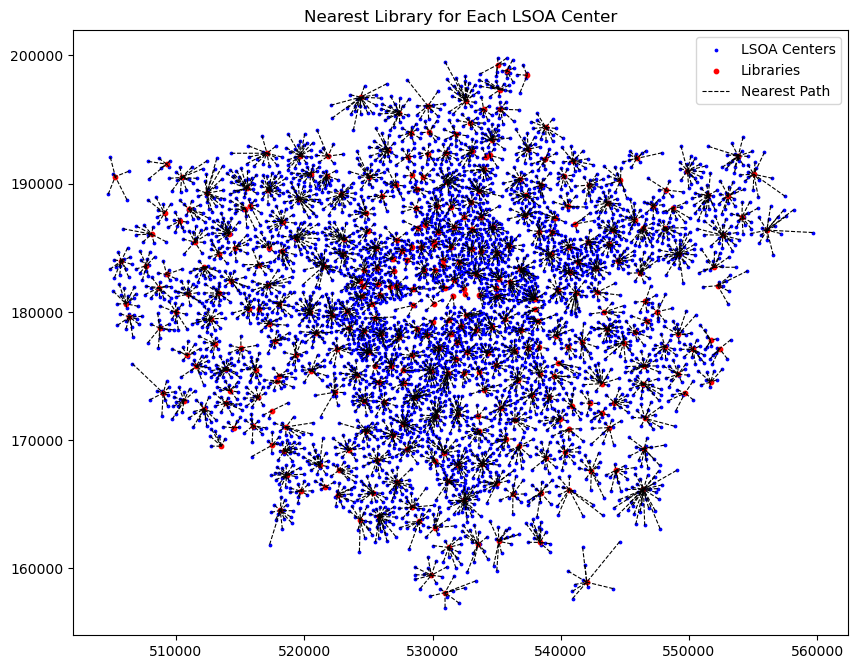

In [63]:
# Plot the map
fig, ax = plt.subplots(figsize=(10, 10))
# Plot LSOA centroids
lsoa_gdf_1.plot(ax=ax, color='blue', markersize=3, label='LSOA Centers')
# Plot library locations
libraries_gdf_1.plot(ax=ax, color='red', markersize=10, label='Libraries')
# Plot the lines
lines_gdf.plot(ax=ax, color='black', linewidth=0.8, linestyle='--', label='Nearest Path')
# Add a legend
plt.legend()
# Add a title
plt.title('Nearest Library for Each LSOA Center')
# Display the map
plt.show()

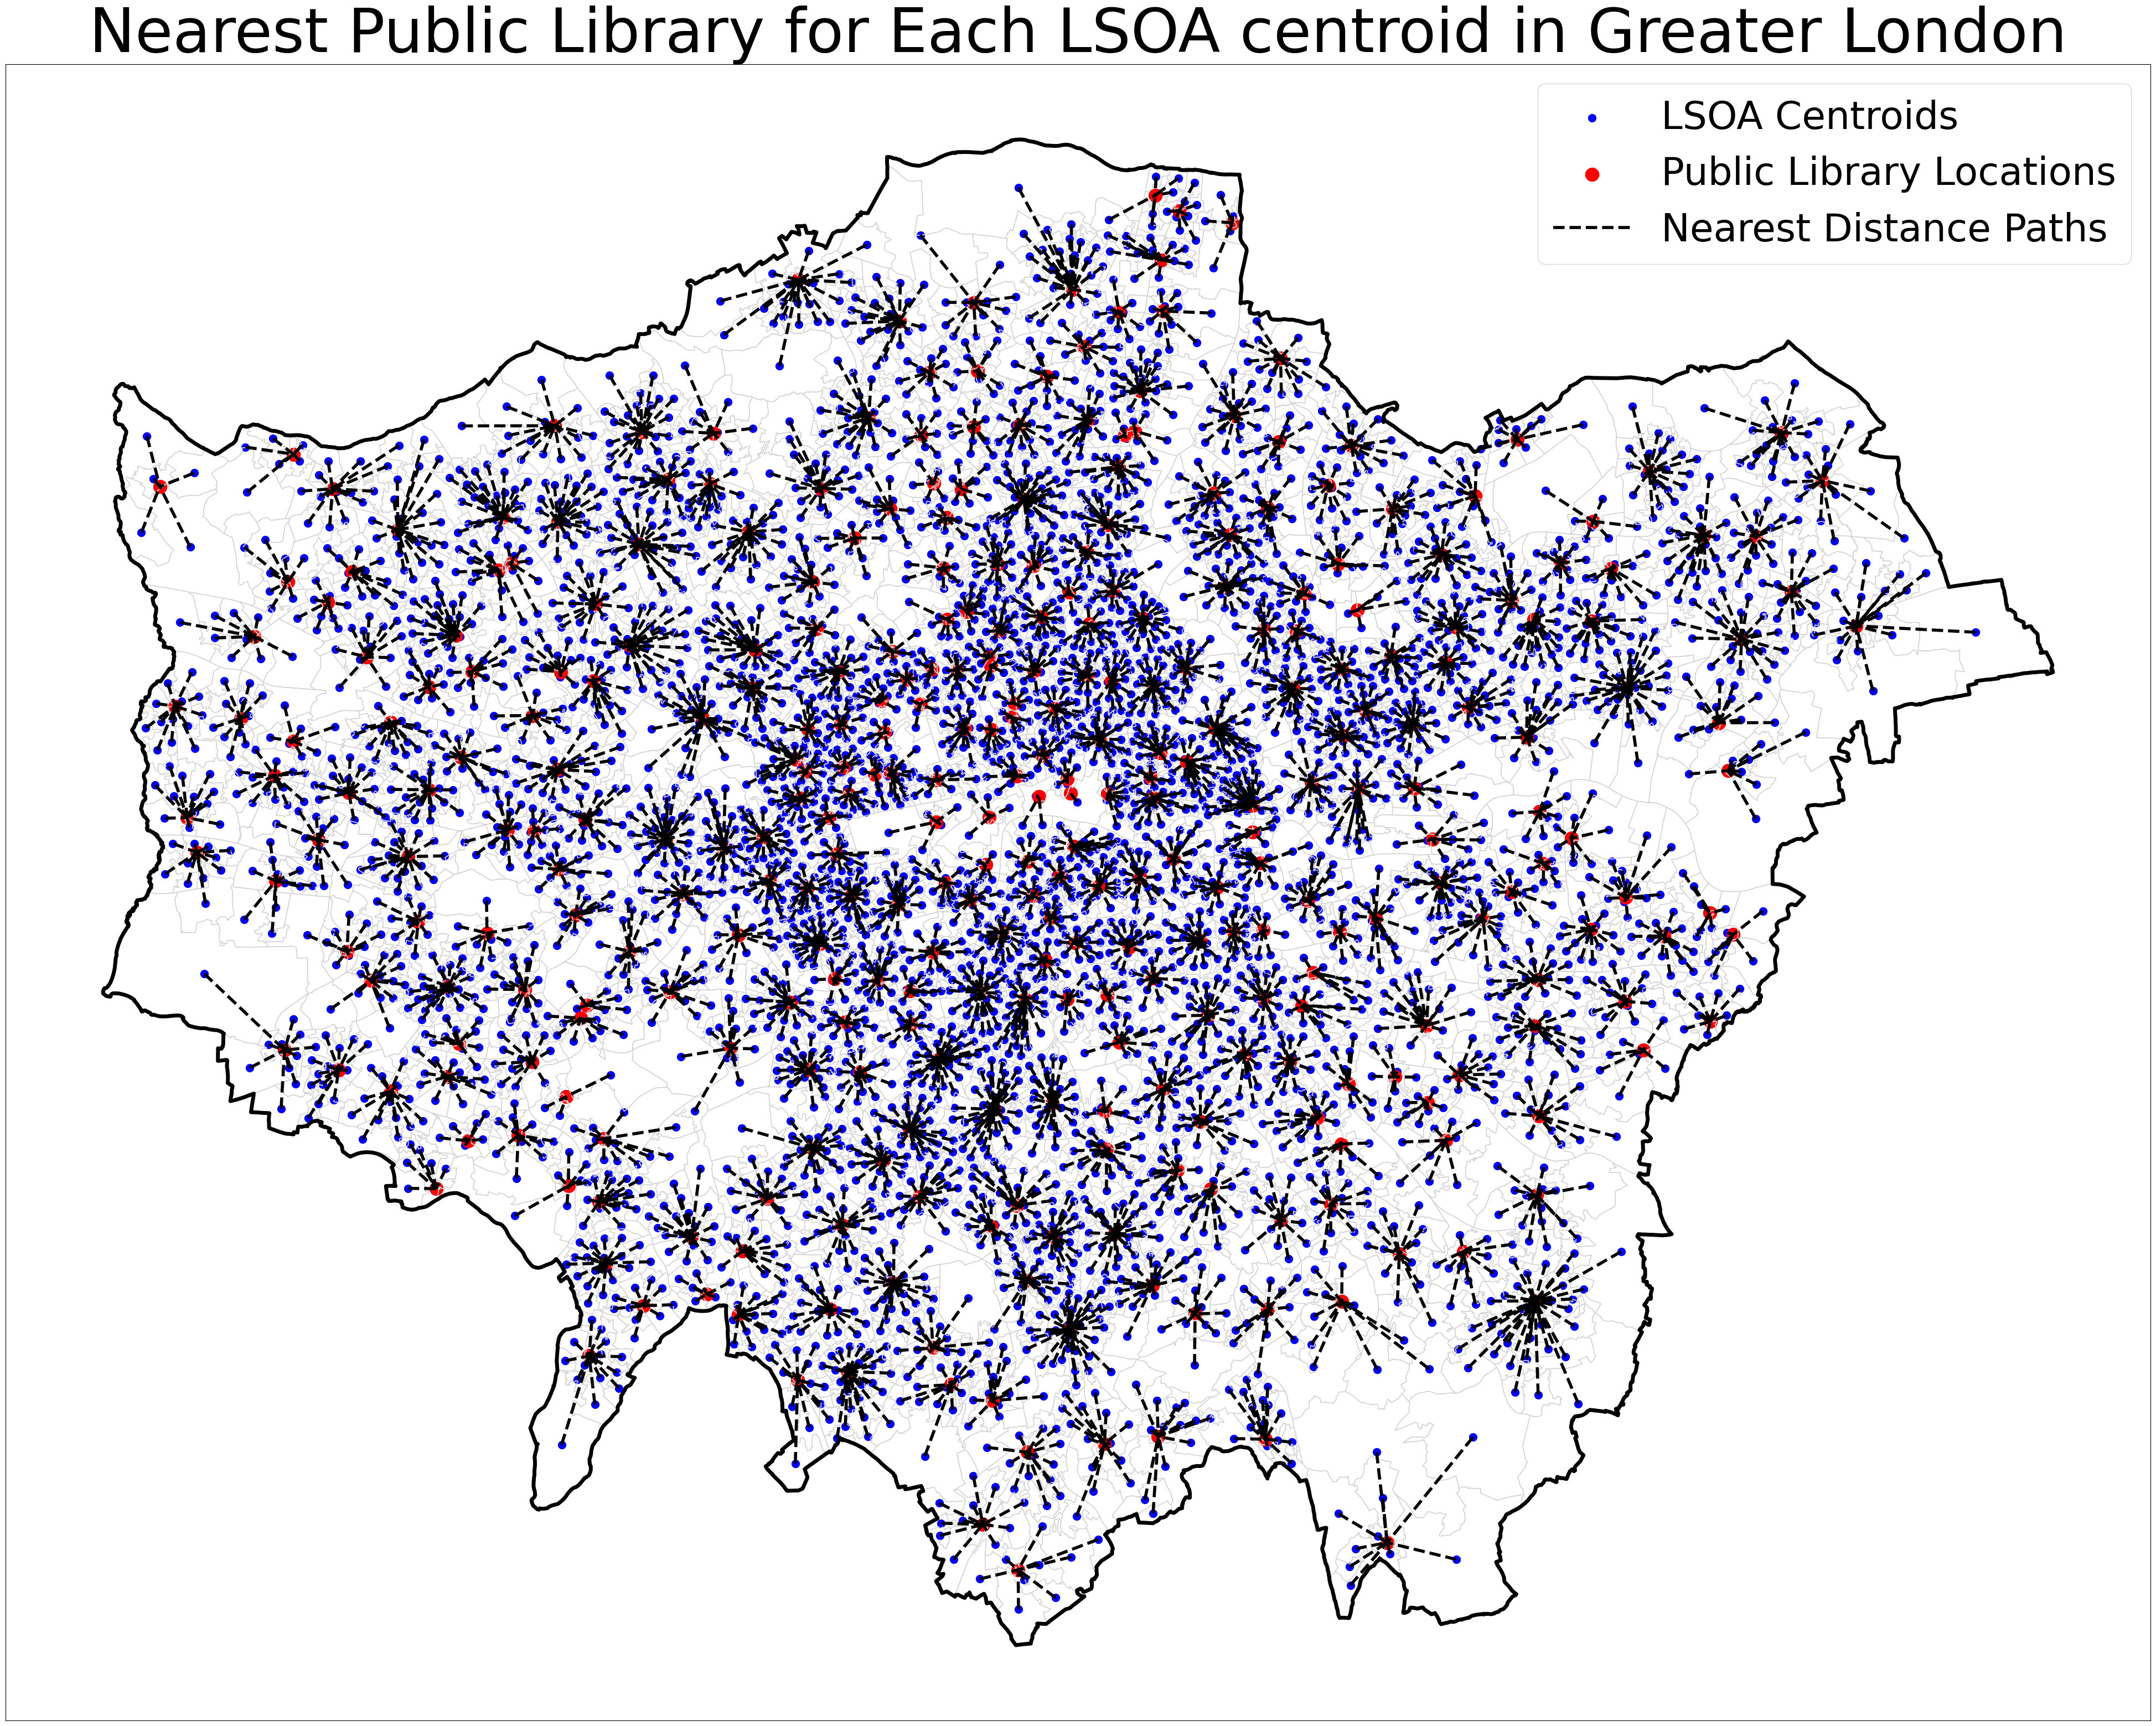

In [132]:
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import MultiPolygon

# Set the figure size
fig, ax = plt.subplots(figsize=(50, 50))

# Plot the London boundary map as the background
London_LSOA_dropped.boundary.plot(ax=ax, color='lightgray', linewidth=1)

# Plot the outermost boundary
outer_boundary = gpd.GeoSeries([London_LSOA_dropped.unary_union])
outer_boundary.boundary.plot(ax=ax, color='black', linewidth=5)  # Adjust linewidth to make it thicker

# Plot LSOA centroids
lsoa_gdf_1.plot(ax=ax, color='blue', markersize=100, label='LSOA Centroids')

# Plot public library locations
libraries_gdf_1.plot(ax=ax, color='red', markersize=300, label='Public Library Locations')

# Plot nearest distance paths
lines_gdf.plot(ax=ax, color='black', linewidth=4, linestyle='--', label='Nearest Distance Paths')

# Add legend
plt.legend(fontsize=50)  # Set the font size of the legend here

# Add title
plt.title('Nearest Public Library for Each LSOA Centroid in Greater London', fontsize=80)

# Remove axis labels but keep the border
ax.set_xticks([])  # Remove x-axis labels
ax.set_yticks([])  # Remove y-axis labels

# Keep the border
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)

# Save the image to the specified path
plt.savefig("Plot_final_0826/NNA.png")

# Display the map
plt.show()